In [ ]:
import random
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
!pip install torchaudio

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as AT
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/open (3).zip"

In [ ]:
train_df = pd.read_csv('/content/train.csv') # 모두 정상 Sample
test_df = pd.read_csv('/content/test.csv')

In [ ]:
train_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


In [ ]:
test_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE
0,TEST_0000,./test/TEST_0000.wav,2
1,TEST_0001,./test/TEST_0001.wav,2
2,TEST_0002,./test/TEST_0002.wav,0
3,TEST_0003,./test/TEST_0003.wav,0
4,TEST_0004,./test/TEST_0004.wav,0
...,...,...,...
1509,TEST_1509,./test/TEST_1509.wav,0
1510,TEST_1510,./test/TEST_1510.wav,2
1511,TEST_1511,./test/TEST_1511.wav,0
1512,TEST_1512,./test/TEST_1512.wav,0


In [ ]:
file_name = '/content/train/TRAIN_0000.wav'
x, sr = torchaudio.load(file_name)
print(x.shape, sr)

torch.Size([8, 160000]) 16000


8개 channel(녹음한 마이크의 갯수), 160000---> 데이터의 길이, 16000---> sr

In [ ]:
print(x.shape[1]/sr)

10.0


10초의 음성파일 시간

음성 데이터를 시각화

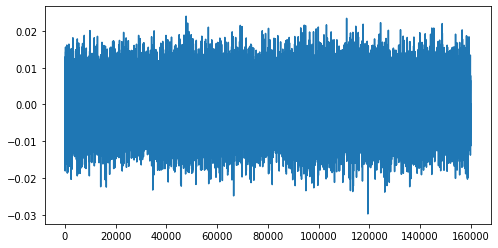

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x[0, :])
plt.show()

# spectrum
stft를 한 결과물에 l2 norm을 거치면, spectrum이 된다.

#melspectrogram
melspectrogram : melspectrogram은 spectrogram에 mel-filter라는 필터를 적용해서 얻어집니다. 이는 사람의 청각 기관이 고음에서 주파수의 변화에 덜 민감하고 저음에서 더 민감한 특징을 반영하고 있습니다. 딥러닝과 사람의 청각 반응은 관련이 없어 보일 수 있으나 음성 처리나 자연어 처리 분야에서도 melspectrogram은 널리 사용되고 있으며 좋은 성능을 보여줍니다. 또한, melspectrogram은 spectrogram보다 크기가 작아서 학습 속도 등에서 유리한 점이 있습니다.

torchaudio에서는 다음과 같이 spectrogram과 melspectrogram을 얻을 수 있는 프로세스를 정의할 수 있습니다. AmplitudeToDB는 power 단위의 spectrogram 또는 melspectrogram을 dB(로그) 단위로 변환해 줍니다. 개인적으로 dB 단위가 딥러닝 모델이 이해하기 편한 범위의 값을 제공한다고 생각합니다.

n_fft : win_length의 크기로 잘린 음성의 작은 조각은 0으로 padding 되어서 n_fft로 크기가 맞춰집니다. 그렇게 padding 된 조각에 푸리에 변환이 적용됩니다. n_fft는 따라서 win_length 보다 크거나 같아야 하고 일반적으로 속도를 위해서 2^n의 값으로 설정합니다.

win_length : 이는 원래 음성을 작은 조각으로 자를 때 작은 조각의 크기를 의미합니다. 자연어 처리 분야에서는 25m의 크기를 기본으로 하고 있으며 16000Hz인 음성에서는 400에 해당하는 값입니다.

즉 win_length는 hz/40을 한 값이 된다.

hop_length : 이는 음성을 작은 조각으로 자를 때 자르는 간격을 의미합니다. 즉, 이 길이만큼 옆으로 밀면서 작은 조각을 얻습니다. 일반적으로 10ms의 크기를 기본으로 하고 있으며 16000Hz인 음성에서는 160에 해당하는 값입니다.

hop_length는 hz/100을 한 값이 된다


n_mels : 적용할 mel filter의 개수를 의미합니다.

In [ ]:
spectrogram = nn.Sequential(
    AT.Spectrogram(n_fft=512, 
                   win_length=400, 
                   hop_length=160),
    AT.AmplitudeToDB()
)

mel_spectrogram = nn.Sequential(
    AT.MelSpectrogram(sample_rate=sr, 
                      n_fft=512, 
                      win_length=400,
                      hop_length=160,
                      n_mels=80),
    AT.AmplitudeToDB()
)

이제 실제 음성 데이터로부터 spectrogram과 melspectrogram을 얻어 보겠습니다. 각각의 크기는 채널을 무시하면 [257, 101], [80, 101]인데 101은 시간축 방향 성분 수, 257과 80은 주파수 방향 성분 수를 의미합니다. n_mel이 80이었으므로 melspectrogram의 주파수 방향 성분 수는 80인 것입니다. spectrogram의 경우 (n_fft / 2 + 1) 개의 주파수 방향 성분이 얻어지게 됩니다. 주파수 성분은 0Hz부터 sampling rate의 절반 즉, 8000Hz까지를 나타내게 됩니다. sampling rate의 절반까지 밖에 표현하지 못하는 이유는 Nyquist frequency에 대해 알아보시면 이해하실 수 있을 것입니다.

In [ ]:
spec = spectrogram(x)
mel = mel_spectrogram(x)
print(spec.shape, mel.shape)

torch.Size([8, 257, 1001]) torch.Size([8, 80, 1001])


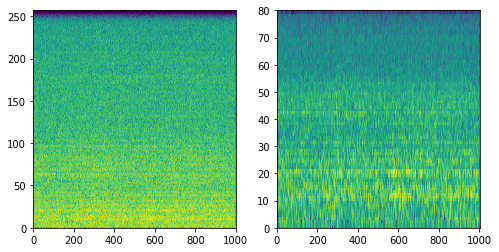

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].pcolor(spec[0])
ax[1].pcolor(mel[0])
plt.show()

마지막으로 spectrogram과 melspectrogram의 해상력에 대해 설명하겠습니다. win_length가 커질수록 주파수 성분에 대한 해상력은 높아지지만, 즉 더 정밀해지지만, 시간 성분에 대한 해상력은 낮아지게 됩니다. 즉, 더 정밀한 주파수 분포를 얻을 수 있으나 시간에 따른 주파수 변화를 관찰하기가 어려워집니다. 반대로 win_length가 작은 경우에는 주파수 성분에 대한 해상력은 낮아지지만, 시간 성분에 대한 해상력은 높아지게 됩니다. 따라서 적절한 값을 찾는 것이 중요합니다. 또한, n_fft를 키우는 경우 주파수 성분의 수는 증가할지 몰라도 실제 주파수의 해상력은 증가하지 않습니다.

#Normalized log mel-spectrogram의 python 구현

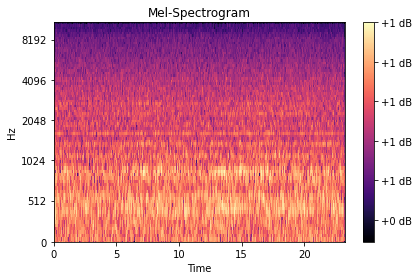

In [17]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt 


min_level_db= -100
def normalize_mel(S):
    return np.clip((S-min_level_db)/-min_level_db,0,1)


def feature_extraction(path):
    y = librosa.load(path,16000)[0]
    S =  librosa.feature.melspectrogram(y=y, n_mels=80, n_fft=512, win_length=400, hop_length=160) # 320/80
    norm_log_S = normalize_mel(librosa.power_to_db(S, ref=np.max))
    return norm_log_S
                        

a = feature_extraction('/content/train/TRAIN_0000.wav')
librosa.display.specshow(a, y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.savefig('Mel-Spectrogram example.png')
plt.show()